In [ ]:
 from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install pyod

     |████████████████████████████████| 113 kB 15.0 MB/s 
  Created wheel for pyod: filename=pyod-0.9.5-py3-none-any.whl size=132699 sha256=3bb877f05cb341d6c9d85ffc9c471c8cf389563db417188868431fa586145289
  Stored in directory: /root/.cache/pip/wheels/3d/bb/b7/62b60fb451b33b0df1ab8006697fba7a6a49709a629055cf77
Successfully built pyod


In [ ]:
!pip install combo

  Created wheel for combo: filename=combo-0.1.2-py3-none-any.whl size=42025 sha256=17a77ca3279a67f31967199a03d82dfedba3ca073271478f00684b47d0e239ab
  Stored in directory: /root/.cache/pip/wheels/cf/2e/45/d4cb985fb061e3ab636d350b76114d2639d84eab16225c7776
Successfully built combo


In [ ]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler


from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

* **It considers the relationship between each point and its neighbor(s). It does not consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score**
* **ABOD** performs well on multi-dimensional data
* **PyOD** provides two different versions of ABOD:
     * **Fast ABOD**: Uses k-nearest neighbors to approximate
     * **Original ABOD**: Considers all training points with high-time complexity

## **Parameters**

* **contamination** (float in (0., 0.5), optional (default=0.1)) – The amount of contamination of the data set, i

* **n_neighbors** (int, optional (default=10)) – Number of neighbors to use by default for k neighbors queries.

* **method** (str, optional (default='fast')) – Valid values for metric are:

      * **’fast’**: fast ABOD. Only consider n_neighbors of training points

      * **’default**’: original ABOD with all training points, which could be slow

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Udemy courses/Proper for recording/train.csv')

In [ ]:
df.head(2)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228


## **Item_MRP** : Maximum Retail Price (list price) of the product
## **Item_Outlet_Sales** :	Sales of the product in the particular store

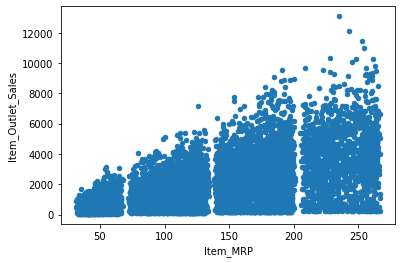

In [ ]:
df.plot.scatter('Item_MRP','Item_Outlet_Sales')

In [ ]:

cols = ['Item_MRP', 'Item_Outlet_Sales']
##Scaling Sales and Profit to between zero and one.
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Item_MRP','Item_Outlet_Sales']] = minmax.fit_transform(df[['Item_MRP', 'Item_Outlet_Sales']])
X1 = df['Item_MRP'].values.reshape(-1,1)
X2 = df['Item_Outlet_Sales'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)


In [ ]:
X

array([[0.92750715, 0.28358666],
       [0.0720684 , 0.03141895],
       [0.46828841, 0.15811486],
       ...,
       [0.22849221, 0.08885035],
       [0.30493925, 0.13883505],
       [0.18750976, 0.05610527]])

OUTLIERS: 77 INLIERS: 8446


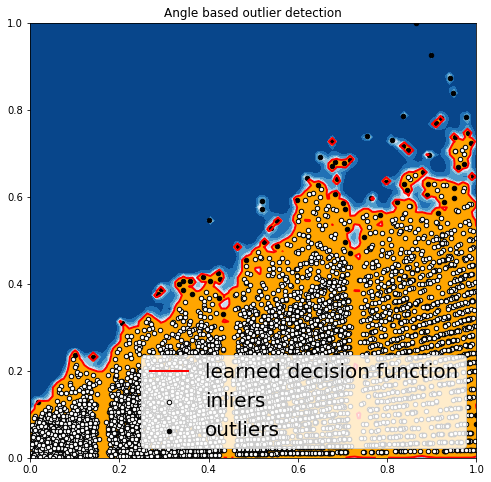

In [ ]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = ABOD(contamination=0.01,n_neighbors=12)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Item_MRP'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Item_Outlet_Sales'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Item_MRP'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Item_Outlet_Sales'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# Use threshold value to consider a datapoint inlier or outlier
# threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Angle based outlier detection')
plt.show();